C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0462 - val_loss: 0.0088
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

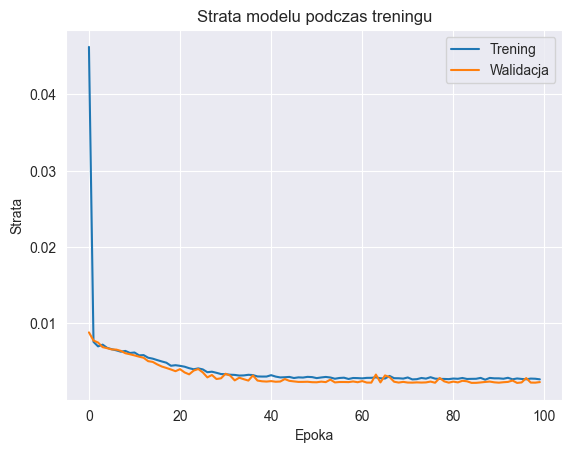

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


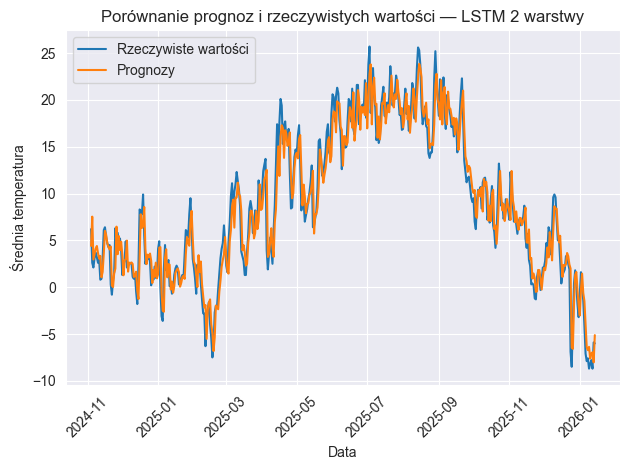

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# =========================
# Wczytanie i przygotowanie danych
# =========================
df = pd.read_csv(
    "european_capitals_history_clean2.csv",
    parse_dates=["time"]
)

df_city = df[df['city'] == 'Warszawa']
df_city = df_city[['time', 'city', 'temp']]
df_city.sort_values(by=["time"], inplace=True)

# =========================
# Tworzenie sekwencji czasowych
# =========================

def create_sequences(df, window=20):  # <- zmienione z 5 na 10
    sequences = []
    labels = []
    for i in range(len(df) - window):
        seq = df.iloc[i:i + window]['temp'].values
        label = df.iloc[i + window]['temp']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Tworzenie sekwencji z nowym window
sequences, labels = create_sequences(df_city, window=20)

# =========================
# Normalizacja danych
# =========================
scaler = MinMaxScaler()
sequences_scaled = scaler.fit_transform(sequences.reshape(-1, 1)).reshape(sequences.shape)
labels_scaled = scaler.transform(labels.reshape(-1, 1))
sequences_scaled = sequences_scaled.reshape((sequences_scaled.shape[0], sequences_scaled.shape[1], 1))

# =========================
# Podział na zbiór treningowy i testowy
# =========================
train_size = int(len(sequences_scaled) * 0.8)
X_train = sequences_scaled[:train_size]
X_test  = sequences_scaled[train_size:]
y_train = labels_scaled[:train_size]
y_test  = labels_scaled[train_size:]

# =========================
# Budowa modelu LSTM z dwiema warstwami
# =========================
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# =========================
# EarlyStopping
# =========================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# =========================
# Trenowanie modelu
# =========================
history = model.fit(
    X_train,
    y_train,
    epochs=100,           # można zwiększyć liczbę epok, EarlyStopping zatrzyma trening wcześniej
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# =========================
# Zapis modelu
# =========================
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "lstm_warszawa_2layers.keras")
model.save(model_path)
print(f"Model zapisany w: {model_path}")

# =========================
# Wizualizacja straty
# =========================
plt.plot(history.history['loss'], label='Trening')
plt.plot(history.history['val_loss'], label='Walidacja')
plt.legend()
plt.title("Strata modelu podczas treningu")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.show()

# =========================
# Predykcja na zbiorze testowym
# =========================
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.plot(df_city['time'].iloc[-len(y_test_rescaled):], y_test_rescaled, label='Rzeczywiste wartości')
plt.plot(df_city['time'].iloc[-len(predictions_rescaled):], predictions_rescaled, label='Prognozy')
plt.legend()
plt.title("Porównanie prognoz i rzeczywistych wartości — LSTM 2 warstwy")
plt.xlabel("Data")
plt.ylabel("Średnia temperatura")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# =========================
# Funkcja budująca model LSTM z 2 warstwami i Dropout
# =========================
def build_lstm_model(input_shape):
    model = Sequential()
    # Pierwsza warstwa LSTM zwracająca sekwencję
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    # Druga warstwa LSTM zwracająca tylko ostatnią wartość
    model.add(LSTM(units=32, return_sequences=False))
    # Warstwa wyjściowa
    model.add(Dense(1))
    # Kompilacja
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# =========================
# Time Series Cross-Validation
# =========================
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
mae_scores  = []
mse_scores  = []
r2_scores   = []

fold = 1

for train_index, test_index in tscv.split(sequences_scaled):
    print(f"\nFold {fold}")

    X_train = sequences_scaled[train_index]
    X_test  = sequences_scaled[test_index]

    y_train = labels_scaled[train_index]
    y_test  = labels_scaled[test_index]

    model = build_lstm_model(input_shape=(X_train.shape[1], 1))

    # =========================
    # EarlyStopping
    # =========================
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model.fit(
        X_train,
        y_train,
        epochs=100,           # EarlyStopping zatrzyma trening wcześniej
        batch_size=32,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        shuffle=False
    )

    y_pred = model.predict(X_test)

    # Odwrócenie skalowania
    y_test_rescaled = scaler.inverse_transform(y_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    mse  = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2   = r2_score(y_test_rescaled, y_pred_rescaled)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(
        f"R²: {r2:.4f} | "
        f"MAE: {mae:.4f} | "
        f"MSE: {mse:.4f} | "
        f"RMSE: {rmse:.4f}"
    )

    fold += 1

# =========================
# Podsumowanie wyników
# =========================
print("\nWalk-Forward Cross-Validation — LSTM (2 warstwy + EarlyStopping)")
print(f"R²   : {np.mean(r2_scores):.4f}")
print(f"MAE  : {np.mean(mae_scores):.4f}")
print(f"MSE  : {np.mean(mse_scores):.4f}")
print(f"RMSE : {np.mean(rmse_scores):.4f}")



Fold 1


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R²: 0.8017 | MAE: 3.0527 | MSE: 14.5472 | RMSE: 3.8141

Fold 2


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R²: 0.9190 | MAE: 1.7486 | MSE: 4.9978 | RMSE: 2.2356

Fold 3


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R²: 0.9194 | MAE: 1.8776 | MSE: 5.8242 | RMSE: 2.4133

Fold 4


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R²: 0.9234 | MAE: 1.7554 | MSE: 4.8939 | RMSE: 2.2122

Fold 5


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R²: 0.9293 | MAE: 1.6925 | MSE: 4.6191 | RMSE: 2.1492

Walk-Forward Cross-Validation — LSTM (2 warstwy + EarlyStopping)
R²   : 0.8985
MAE  : 2.0253
MSE  : 6.9764
RMSE : 2.5649


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


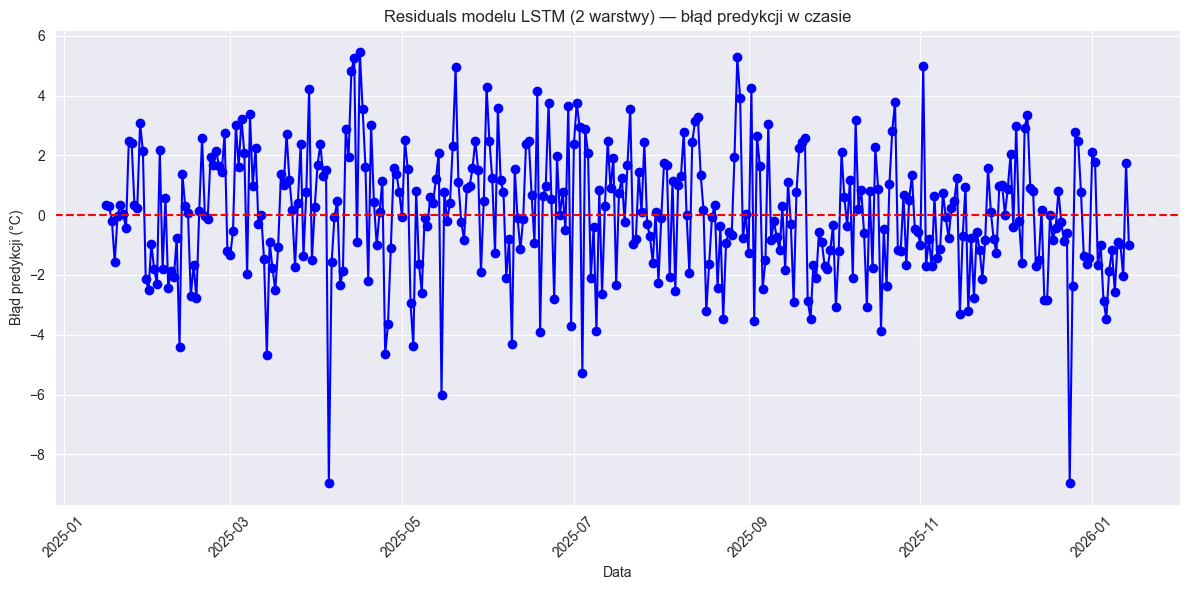

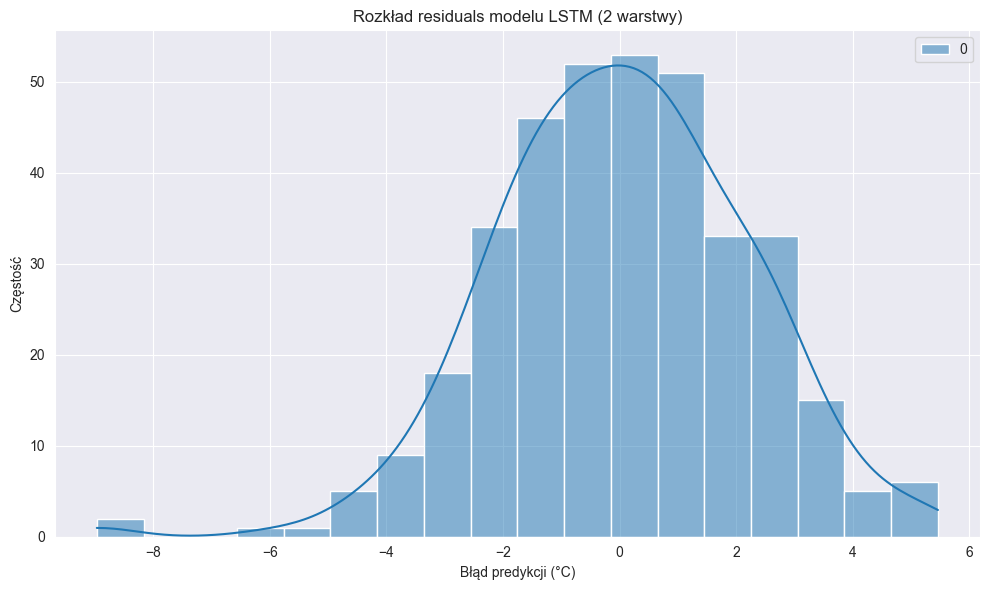

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================
# Predykcja na zbiorze testowym
# =========================
predictions = model.predict(X_test)

# Odwrócenie skalowania
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Dopasowanie długości (czasem w LSTM występuje różnica długości)
min_len = min(len(y_test_rescaled), len(predictions_rescaled))
y_test_rescaled = y_test_rescaled[:min_len]
predictions_rescaled = predictions_rescaled[:min_len]

# =========================
# Obliczenie residuals
# =========================
residuals = y_test_rescaled - predictions_rescaled

# =========================
# Wykres residuals w czasie
# =========================
plt.figure(figsize=(12,6))
plt.plot(
    df_city['time'].iloc[-len(residuals):],
    residuals,
    marker='o',
    linestyle='-',
    color='b'
)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals modelu LSTM (2 warstwy) — błąd predykcji w czasie')
plt.xlabel('Data')
plt.ylabel('Błąd predykcji (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# Histogram residuals
# =========================
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, color='b')
plt.title('Rozkład residuals modelu LSTM (2 warstwy)')
plt.xlabel('Błąd predykcji (°C)')
plt.ylabel('Częstość')
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/100


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0643 - val_loss: 0.0112
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - val_loss: 0.0091
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - val_loss: 0.0092
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - val_loss: 0.0092
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 0.0109
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - val_loss: 0.0087
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - val_l

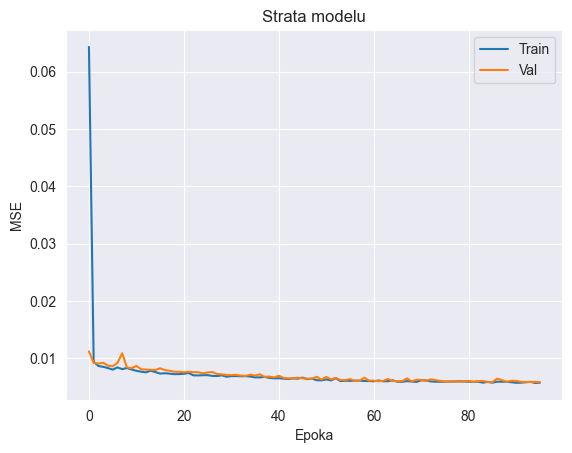

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


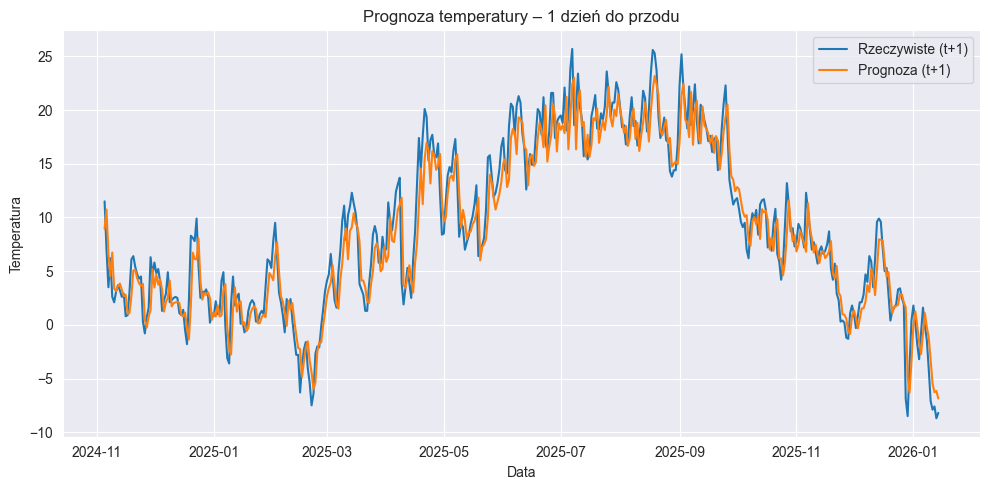

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prognoza na 5 dni do przodu:
Dzień +1: -6.86 °C
Dzień +2: -4.31 °C
Dzień +3: -3.37 °C
Dzień +4: -2.61 °C
Dzień +5: -1.92 °C


In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# =========================
# 1. Wczytanie danych
# =========================
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])
df_city = df[df['city'] == 'Warszawa'][['time', 'temp']]
df_city.sort_values(by="time", inplace=True)
df_city.reset_index(drop=True, inplace=True)

# =========================
# 2. Tworzenie sekwencji (multi-step)
# =========================
def create_sequences(df, window=20, forecast_horizon=5):
    X, y = [], []
    for i in range(len(df) - window - forecast_horizon + 1):
        X.append(df.iloc[i:i+window]['temp'].values)
        y.append(df.iloc[i+window:i+window+forecast_horizon]['temp'].values)
    return np.array(X), np.array(y)

WINDOW = 20
FORECAST = 5
X, y = create_sequences(df_city, WINDOW, FORECAST)

# =========================
# 3. Podział TRAIN / TEST
# =========================
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# =========================
# 4. Normalizacja (BEZ LEAKAGE)
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(X_train.reshape(-1, 1))
scaler_y.fit(y_train)

X_train_scaled = scaler_X.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# LSTM shape: [samples, timesteps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], WINDOW, 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], WINDOW, 1))

# =========================
# 5. Model LSTM
# =========================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(FORECAST)
])

model.compile(optimizer='adam', loss='mse')

# =========================
# 6. EarlyStopping
# =========================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# =========================
# 7. Trening
# =========================
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

# =========================
# 8. Zapis modelu
# =========================
os.makedirs("models", exist_ok=True)
model.save("models/lstm_warszawa_5dni.keras")

# =========================
# 9. Wykres straty
# =========================
plt.figure()
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend()
plt.title("Strata modelu")
plt.xlabel("Epoka")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

# =========================
# 10. Predykcja TEST (TYLKO t+1)
# =========================
pred_scaled = model.predict(X_test_scaled)
pred = scaler_y.inverse_transform(pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test_scaled)

# t+1
pred_t1 = pred[:, 0]
y_t1 = y_test_real[:, 0]

time_axis = df_city['time'].iloc[-len(y_t1):]

plt.figure(figsize=(10,5))
plt.plot(time_axis, y_t1, label='Rzeczywiste (t+1)')
plt.plot(time_axis, pred_t1, label='Prognoza (t+1)')
plt.legend()
plt.title("Prognoza temperatury – 1 dzień do przodu")
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# 11. Prognoza 5 dni w przyszłość
# =========================
last_sequence = X_test_scaled[-1].reshape(1, WINDOW, 1)
future_scaled = model.predict(last_sequence)
future = scaler_y.inverse_transform(future_scaled)

print("Prognoza na 5 dni do przodu:")
for i, val in enumerate(future.flatten(), 1):
    print(f"Dzień +{i}: {val:.2f} °C")
